<a href="https://colab.research.google.com/github/Samarth745/Credit-Card-Risk-Analysis/blob/main/Credit%20Risk%20Analysis%20New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
#@title Import
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency, pearsonr
import re

pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')


In [410]:
#@title Import Main DataFrame
data = pd.read_csv("/content/drive/MyDrive/Credit Risk Analysis/CreditRisk/loan/loan.csv")

In [411]:
#@title Create Columns Defination Dictionary
## This Dictionary will define columns based on keys
ColDoc = pd.read_excel("/content/drive/MyDrive/Credit Risk Analysis/CreditRisk/LCDataDictionary.xlsx").set_index("LoanStatNew")["Description"].to_dict()

## Data Demographics and Issues in Data
- 887379 Rows, 74 Columns
- Two Id Columns `id, member_id`
- Target colum `loan_status`
- There Are a lot of missing values, some of the columns with more than 50% data missing
- No Duplications
- - No direct duplicated values
- - No member Id duplicated
- - No two members with same features
- All the datecolumns are in format (MM-YYYY), All Srings
- `timedelta features are in text format of types (<1 year, 10+ year etc)
- columns `policy code` has no unique values
- A lot of columns have hardly 30 unique values in it which can be termed as categorical



In [412]:
#@title Shape
f"Total Number of Rows in Data {data.shape[0]}, Total Number of Columns in Data{data.shape[1]}"

'Total Number of Rows in Data 887379, Total Number of Columns in Data74'

In [413]:
#@title Null Values in Data Frame
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False)

dti_joint                    0.999426
annual_inc_joint             0.999424
verification_status_joint    0.999424
il_util                      0.979020
mths_since_rcnt_il           0.976549
                               ...   
total_pymnt                  0.000000
total_pymnt_inv              0.000000
total_rec_prncp              0.000000
total_rec_int                0.000000
out_prncp_inv                0.000000
Length: 74, dtype: float64

As We can see above some of the columns in data frame have 50% of data missing

In [414]:
#@title Direct Duplicates
data.duplicated().sum()

0

In [415]:
#@title Duplicate Entries for members
data.duplicated(subset="member_id").sum()

0

In [416]:
#@title Duplicated Features
data.drop(columns = ["id", "member_id"]).duplicated().sum()

0

In [417]:
#@title Checking the possibility of Categorical Columns
columnsuniquevalues=pd.DataFrame()
for column in data.columns:
  columnsuniquevalues=pd.concat([columnsuniquevalues,pd.DataFrame({column : [(data[column].nunique())]}).T])
  columnsuniquevalues.sort_values(by=0, inplace=True)

## Data Cleaning
- remove `id` and `member_id` columns (Not usable)
- remove all the columns with more than 50% data (Not usable)
- `term` contains binary item, Highly corelated
- - `term` needs to be converted to numeric column hence remove strings
- `emp_length` needs to be converted to numeric hence remove strings
- `title` column delete
- `earliest_cr_line` column delete

---
* MissingValues**
- `annual_inc` missing values handled by fillna(median)
- `emp_len` to be handled using mean
- `["delinq_2yrs",'inq_last_6mths',"open_acc", "pub_rec"]` fillna(mean) less weightage columns
- `revol_util` should be handled using median
- `last_pymnt_d` and `next_pymnt_d` can be removed (Date Columns with no reference)
-  fill `emp_title` with 'random' no information can be built based on prev knowledge

Further rows with null values will be deleted
expected data loss -- `< 0.005%`

---
## Analyse on

- `emp_title` seems to have a lot of empty values, The column seems to be imp after text processing based on random checks (EX: if director is present --> HIgh chances of no default etc)

In [418]:
#@title Now columns with Missing Values
data.isnull().sum()[data.isnull().sum().values!=0].sort_values(ascending=False).head(15)

dti_joint                    886870
annual_inc_joint             886868
verification_status_joint    886868
il_util                      868762
mths_since_rcnt_il           866569
total_cu_tl                  866007
inq_fi                       866007
all_util                     866007
max_bal_bc                   866007
open_rv_24m                  866007
open_rv_12m                  866007
total_bal_il                 866007
open_il_24m                  866007
open_il_12m                  866007
open_il_6m                   866007
dtype: int64

In [419]:
#@title Employee Title
print("-------------------The  data set distribution of loan_status when emp_title contains director -------------------------------------------------------")
data["emp_title"].fillna("random", inplace=True)
data[data["emp_title"].str.contains("irector")]["loan_status"].value_counts()/(data[data["emp_title"].str.contains("irector")]["loan_status"].value_counts()).sum()
temp = data.dropna()[data["emp_title"].str.contains("irector").dropna()]["loan_status"].value_counts()/(data.dropna()[data["emp_title"].str.contains("irector").dropna()]["loan_status"].value_counts()).sum()
print(temp)
print("-------------------While the normal data set distribution of loan_status is -------------------------------------------------------")
data.loan_status.value_counts()/data.shape[0]

-------------------The  data set distribution of loan_status when emp_title contains director -------------------------------------------------------
Series([], Name: loan_status, dtype: float64)
-------------------While the normal data set distribution of loan_status is -------------------------------------------------------


Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

<Axes: ylabel='emp_length'>

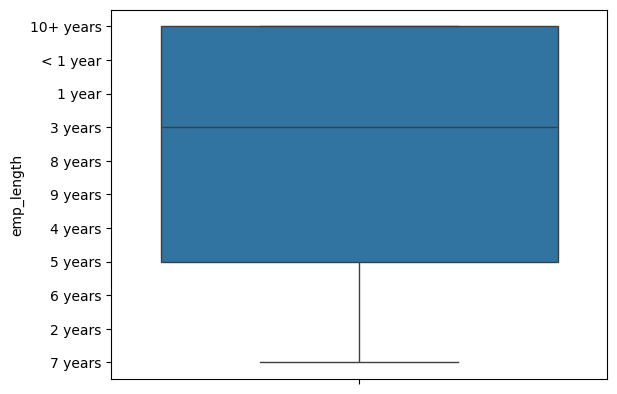

In [420]:
#@title emp_length
sns.boxplot(data["emp_length"])

In [421]:
#@title tot_coll_amt, tot_cur_bal,total_rev_hi_lim --Not a Unique Feature
print(ColDoc["tot_coll_amt"])
data["tot_coll_amt"].value_counts()/data.shape[0]

Total collection amounts ever owed


0.0       0.789906
50.0      0.001978
100.0     0.001529
75.0      0.001176
200.0     0.000805
            ...   
4891.0    0.000001
7184.0    0.000001
4242.0    0.000001
9477.0    0.000001
8567.0    0.000001
Name: tot_coll_amt, Length: 10325, dtype: float64

<Axes: ylabel='revol_util'>

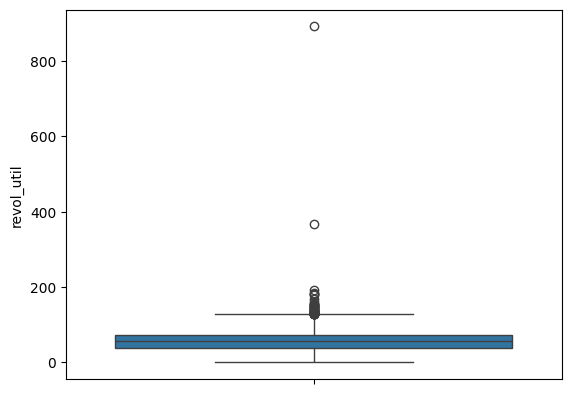

In [422]:
#@title Revol Util
sns.boxplot(data["revol_util"])

In [423]:
#@title pymnt_plan
data["pymnt_plan"].value_counts()

n    887369
y        10
Name: pymnt_plan, dtype: int64

In [424]:
#@title PreProcess -
def preprocess_dfframe(df):
  #@title Removing Id Columns
  try:
    df.set_index('id',inplace=True)
  except:
    pass
  try:
    df.drop(columns=['member_id'], inplace=True)
  except:
    pass

  #@title Removing Columns with More than 50% df missing
  columnswithincompetedf = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)[(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).values>0.5].index.to_list()
  df.drop(columns=columnswithincompetedf, inplace=True)
  df.drop(columns = [ "title", "policy_code", "issue_d","pymnt_plan", 'url', "title", "zip_code", "earliest_cr_line","last_credit_pull_d"],inplace=True)
  # Clean Employee Length
  df["emp_length"] = df["emp_length"].fillna('0').apply(lambda x:int(re.findall(r'\d+',x)[0]) if x!='0' else np.nan)

  ## Clean term
  df["term"] = df["term"].fillna('0').apply(lambda x:int(re.findall(r'\d+',x)[0]) if x!='0' else np.nan)

  ## Drop Unnecessary Columns
  for column in ['tot_coll_amt','last_pymnt_d', 'next_pymnt_d', 'tot_cur_bal', 'total_rev_hi_lim']:
    df[column].fillna(0, inplace=True)

  df["emp_title"].fillna("random", inplace=True)

  df["emp_length"] = df["emp_length"].fillna(df["emp_length"].mean())

  df["revol_util"] = df["revol_util"].fillna(df["revol_util"].median())

  df.dropna(axis=0, inplace=True)


preprocess_dfframe(data)

Data Loss After Preprocessing
- 0.02 % in rows
- 40% (20) in Columns

## EDA
- We need to convert our target variable to binary



In [425]:
#@title Binary Target Data
data["target"] = data["loan_status"].apply(lambda x: 1 if x in ['Current', 'Fully Paid'] else 0)

<Axes: >

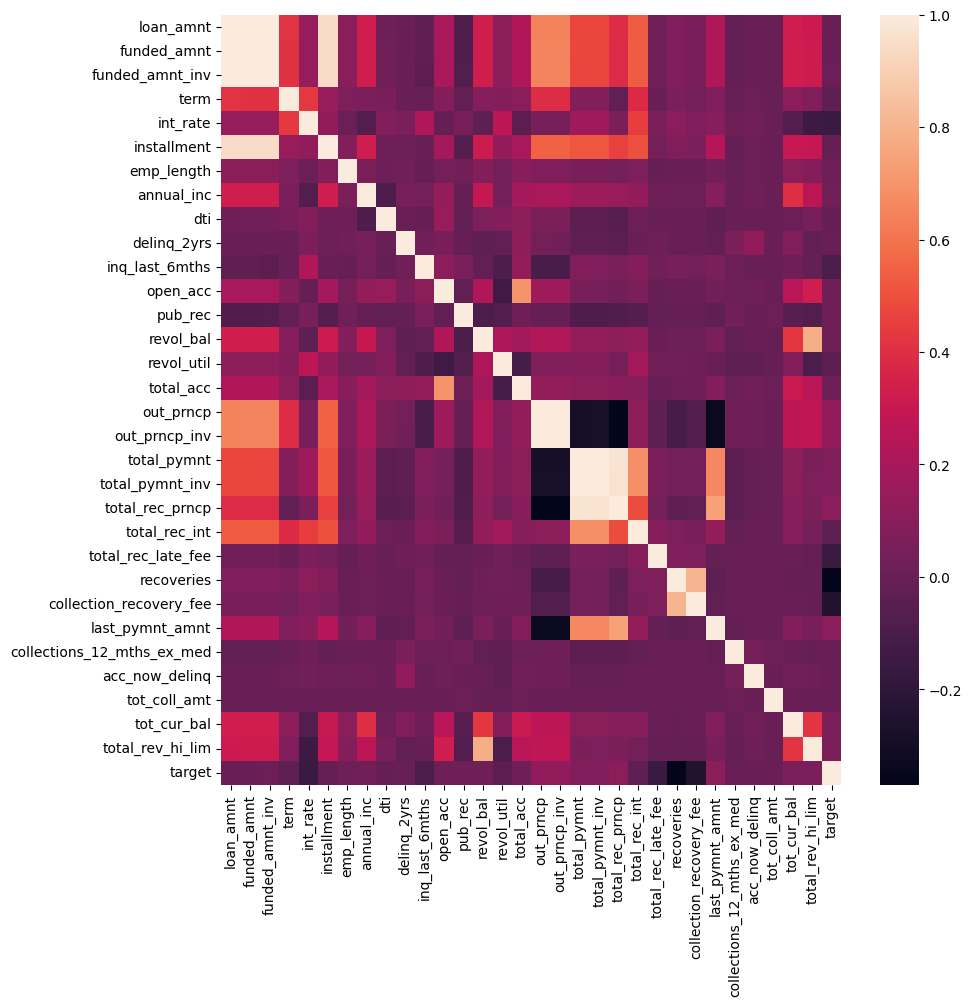

In [426]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())